In [1]:
import numpy as np
import pandas as pd

import os
import glob
import librosa
import tqdm
import pickle
import time

from collections import Counter, defaultdict

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import lr_scheduler
from torch import nn
import torch.nn.functional as F
import torch

from skmultilearn.model_selection import iterative_train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import utils
from flame import Trainer

sns.set()

DATA_PATH = './data'
join_path = lambda path: os.path.join(DATA_PATH, path)

In [2]:
with open(join_path('train_mels.pkl'), 'rb+') as f:
    train_X = pickle.load(f)
    
with open(join_path('val_mels.pkl'), 'rb+') as f:
    val_X = pickle.load(f)
    
train_y = np.load(join_path('train_targets.npy'))
val_y = np.load(join_path('val_targets.npy'))

In [3]:
train_ds = utils.create_ds(train_X, train_y)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = utils.create_ds(val_X, val_y)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.avg_pool2d(x, 2)
        return x

class KaggleModel(nn.Module):
    def __init__(self, num_classes=80):
        super().__init__()
        
        self.conv = nn.Sequential(
            ConvBlock(in_channels=1, out_channels=64),
            ConvBlock(in_channels=64, out_channels=128),
            ConvBlock(in_channels=128, out_channels=256),
            ConvBlock(in_channels=256, out_channels=512),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.PReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.avgpool(x)      
        x = self.fc(x.squeeze(-1).squeeze(-1))
        return x

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()

model = KaggleModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
logdir = join_path('ModifiedDCNN_logdir')

trainer = Trainer(model, optimizer, criterion, device, logdir)

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='max',
    factor=0.5,
    patience=10,
    verbose=True
)

In [9]:
losses, best_loss, epoch_time = utils.train_model(trainer, train_dl, val_dl, val_y, scheduler,
                                            n_epochs=1000, gap=20, verbose=True)

Epoch, best_val_lwlrap
   1, 0.0938
   2, 0.1268
   3, 0.1745
   5, 0.2097
   6, 0.2696
   8, 0.3212
   9, 0.3534
  10, 0.3750
  12, 0.4029
  13, 0.4133
  14, 0.4159
  16, 0.4797
  18, 0.5040
  19, 0.5218
  20, 0.5323
  21, 0.5963
  25, 0.5979
  26, 0.6287
  30, 0.6452
  32, 0.6664
  34, 0.6844
  35, 0.6887
  36, 0.7045
  38, 0.7053
  41, 0.7080
  42, 0.7103
  43, 0.7196
  47, 0.7386
  56, 0.7487
  65, 0.7644
Epoch    76: reducing learning rate of group 0 to 5.0000e-04.
  77, 0.7784
  78, 0.7841
Epoch    89: reducing learning rate of group 0 to 2.5000e-04.
  93, 0.7876
Epoch   104: reducing learning rate of group 0 to 1.2500e-04.
Done.


In [10]:
epoch_time, best_loss

(15.0730343350267, 0.7875656234689363)

Text(0.5, 1.0, 'Logloss')

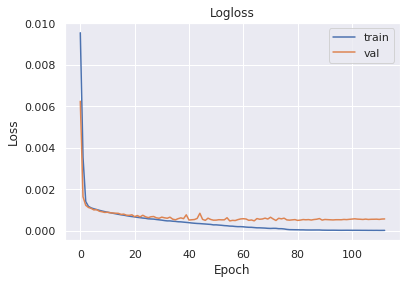

In [11]:
plt.plot(losses['train']['logloss'])
plt.plot(losses['val']['logloss'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Logloss')

Text(0.5, 1.0, 'Lwlrap')

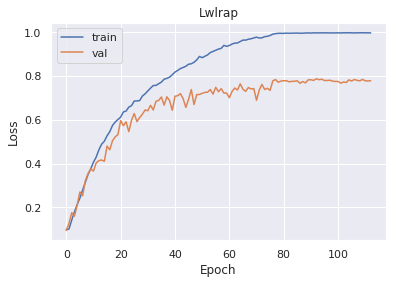

In [12]:
plt.plot(losses['train']['lwlrap'])
plt.plot(losses['val']['lwlrap'])
plt.legend(['train', 'val'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Lwlrap')

In [13]:
with open(join_path('Kaggle_losses.pkl'), 'wb+') as f:
    pickle.dump(losses, f)